<a href="https://colab.research.google.com/github/Titashmkhrj/Quora-question-pair-similarity-detection/blob/master/modelling_questions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project Description  
This is a problem from one of the competitions held on Kaggle.  
Competition name > <u>Quora Question Pairs</u>.  

What is Quora?  
Quora is a place to gain and share knowledge—about anything. It’s a platform to ask questions and connect with people who contribute unique insights and quality answers. This empowers people to learn from each other and to better understand the world.  

# Problem Description  
<i>(a/c the data source)</i>  
Over 100 million people visit Quora every month, so it's no surprise that many people ask similarly worded questions. Multiple questions with the same intent can cause seekers to spend more time finding the best answer to their question, and make writers feel they need to answer multiple versions of the same question. Quora values canonical questions because they provide a better experience to active seekers and writers, and offer more value to both of these groups in the long term.  

# Objective  
<i>(a/c the data source)</i>   
The goal of this competition is to predict which of the provided pairs of questions contain two questions with the same meaning.  

# Data source  
* From **KAGGLE** - https://www.kaggle.com/c/quora-question-pairs

Okay so prime-facie let's import some of the libraries,  
we will import other libraries as we go on a need basis.

In [22]:
import sys

# library to handle vectorized data 
import numpy as np 
# library for data analsysis and man
import pandas as pd 
# so that the output is not trunacated by pandas when we actually want to see it 
pd.set_option('display.max_columns', 1000)
pd.set_option('display.max_rows', 100000)

# for visualisations
import seaborn as sns
%matplotlib inline 
import matplotlib.pyplot as plt


Loading the data.

In [2]:
# training data
train_data = pd.read_csv(r'data/train.csv')
# testing data
test_data = pd.read_csv(r'data/test.csv')

In [3]:
print('''The dimensions of the training data are {} rows and {} columns
\nThe dimensions of the testing data are {} rows and {} columns'''.format(train_data.shape[0], train_data.shape[1],
                                                                         test_data.shape[0], test_data.shape[1]))

The dimensions of the training data are 404290 rows and 6 columns

The dimensions of the testing data are 2345796 rows and 3 columns


In [4]:
# let's take a look at the data
train_data.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [5]:
test_data.head()

,test_id,question1,question2
0,0,How does the Surface Pro himself 4 compare wit...,Why did Microsoft choose core m3 and not core ...
1,1,Should I have a hair transplant at age 24? How...,How much cost does hair transplant require?
2,2,What but is the best way to send money from Ch...,What you send money to China?
3,3,Which food not emulsifiers?,What foods fibre?
4,4,"How ""aberystwyth"" start reading?",How their can I start reading?


In [6]:
# let's check the features in our data
train_data.columns

Index(['id', 'qid1', 'qid2', 'question1', 'question2', 'is_duplicate'], dtype='object')

Feature explanation according to the data source :  
* **id** - the id of a training set question pair
* **qid1**, **qid2** - unique ids of each question (only available in train.csv)
* **question1**, **question2** - the full text of each question
* **is_duplicate** - the target variable, set to 1 if question1 and question2 have essentially the same meaning, and 0 otherwise.

In [7]:
# let's also ckeck the data types of our features
train_data.dtypes

id               int64
qid1             int64
qid2             int64
question1       object
question2       object
is_duplicate     int64
dtype: object


# Handling missing values.

In [8]:
train_data.isnull().sum()

id              0
qid1            0
qid2            0
question1       1
question2       2
is_duplicate    0
dtype: int64

As we can see from above, there are a couple of missing values in this dataset. There is no possibility for impuation of the missing values in our dataset. Hence we are going to drop them.

In [9]:
train_data.dropna(inplace = True)
train_data.shape

(404287, 6)

# Exploratory Data Aanalysis

Let's check some descriptive stats about our data.

In [10]:
'''
Function to print out the descriptive stats
of a feature containing text data.
In this particular case we have sentences that are questions 
as the text feature.
'''
def desc_stat_sent (data, feature) :
    tot_words = data[feature].map(lambda x: len(x.split()))
    avg_words = round(tot_words.mean())
    min_words = round((data[feature].map(lambda x: len(x.split()))).min())
    max_words = round((data[feature].map(lambda x: len(x.split()))).max())
    std_words = round((data[feature].map(lambda x: len(x.split()))).std())
    
    #printing the results
    print('''Descritive statistics for the feature "{}"
    \nAverage number of words in each sentence : {}
    \nStandard deviation in number of words in each sentence : {}
    \nMaximum number of words in a sentence : {}
    \nMinimum number of words in a sentence : {}'''.format(feature,
                                                           avg_words,
                                                           std_words,
                                                           max_words,
                                                           min_words))

In [11]:
desc_stat_sent(train_data, 'question1')

Descritive statistics for the feature "question1"
    
Average number of words in each sentence : 11
    
Standard deviation in number of words in each sentence : 5
    
Maximum number of words in a sentence : 125
    
Minimum number of words in a sentence : 1


In [12]:
desc_stat_sent(train_data, 'question2')

Descritive statistics for the feature "question2"
    
Average number of words in each sentence : 11
    
Standard deviation in number of words in each sentence : 6
    
Maximum number of words in a sentence : 237
    
Minimum number of words in a sentence : 1


### Frequency distribution of the labels in the target feature :   
**is_duplicate** is the target variable,  
set to **1** if <i>question1</i> and <i>question2</i> have essentially the same meaning,  
and set to **0** if <i>question1</i> and <i>question2</i> have otherwise different meaning.  

Okay so we can understand that it is  binary target feature;  
so let's check the frequency distribution of the labels.

>> Percentage of question pairs that are not similar = 63.08 %

>> Percentage of question pairs that are similar = 36.92 %


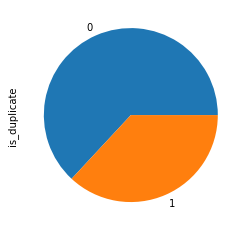

In [13]:
# plotting the frequency distribution
target_freq_dist = train_data['is_duplicate'].value_counts() 
target_freq_dist.plot.pie()
# printing the data related to it
print('''>> Percentage of question pairs that are not similar = {} %
\n>> Percentage of question pairs that are similar = {} %'''.format(round((target_freq_dist[0]/len(train_data))*100,2),
                                                               round((target_freq_dist[1]/len(train_data))*100, 2)))

okay so as we can from above that the frequency distribution of the labels in our targe feature is imbalanced.

### Unique questions :  
okay so now let us check the number of unique questions in our data, and how they are distributed.  

We have two features **qid1** and **qid2**, which contain the unique ids of the questons in our data. From observing the head of our dataset, prime - facie we can understand that the question pairs are made out of consecutive questions; i.e. questoin (1,2), (3,4), (5,6), and so on... From the above pattern we can infer that the pairs consist of consecutive odd and even numbered questions.  

okay, so assuming that given a particular question id there is only one question, let us see how many unique questions we have in our dataset.  

We will also be checking the frequency distribution of the unique questions in our dataset, i.e. assuming for a particular question id there is only one question, if that question is repeated in any other pair, and if so what is the frequency of such repetitions in our data.

In [14]:
# checking the number of unique questions, assuing that gven a particular question id there is only one question
question_ids = pd.Series(train_data['qid1'].tolist() + train_data['qid2'].tolist())
print('The number of unique questions in our dataset are ', len(np.unique(question_ids)), ' questions.')

The number of unique questions in our dataset are  537929  questions.


In [35]:
# checking the frequency of repetition of each unique question
freq_dict = {'no_of_questions' : ((question_ids.value_counts()).value_counts()).values,
             'frequency_of_repitition' : ((question_ids.value_counts()).value_counts()).index
                }

freq_of_questions = pd.DataFrame(freq_dict)

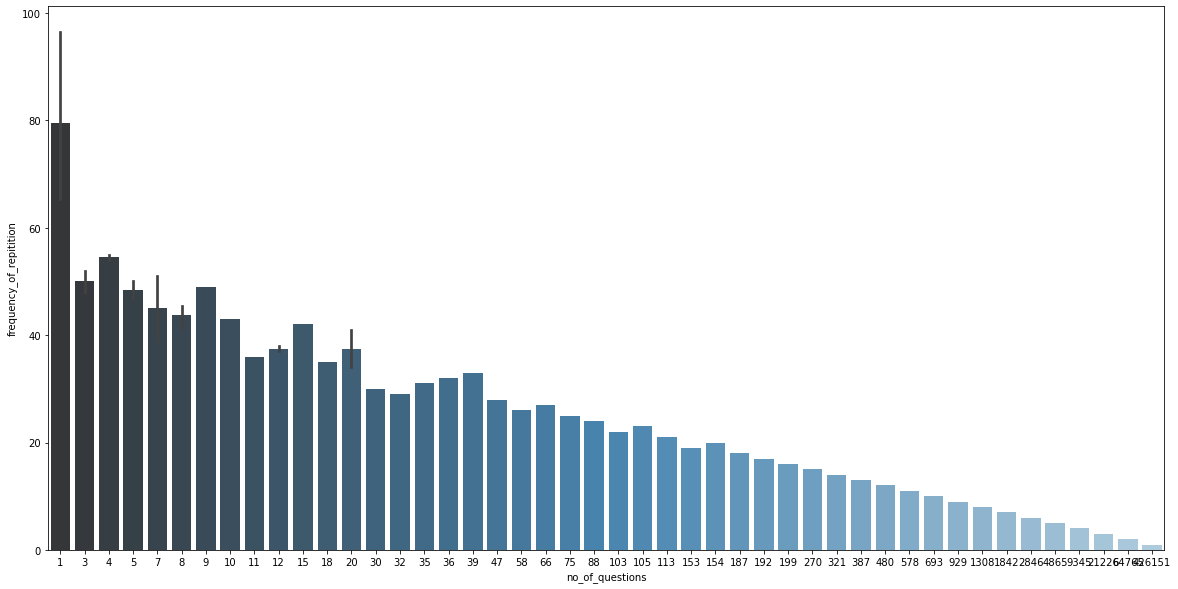

In [44]:
# plotting the above finding
plt.figure(figsize=(20, 10))
# sns.set_theme(style="blackgrid")
sns.barplot(x = "no_of_questions",
            y = "frequency_of_repitition",
            data=freq_of_questions,
            palette="Blues_d")
plt.show()

Observations : 
* 426153 number of questions have no repetitions in our dataset, which means 111780 questions have repetitions in our dataset.
* The frequncy distribution of repetitions of questions range from 1 to 157.
* The frequency of repetition of questions is inversly proportionate to the number od questions repeated for that particular frequency.


### Checking for duplicate rows in our data.

Assuming all the questions in our feature **question1** and **question2** have unique IDs i.e. **qid1** and **qid2** -   
We can define a duplicated instance in our data if the values of the fetures in **qid1 , qid2** and **is_duplicate** are same for any two instance.  

In [46]:
#checking whether there are any repeated pair of questions
pair_duplicates = train_data[['qid1','qid2','is_duplicate']].groupby(['qid1','qid2']).count().reset_index()
print ("Number of duplicate questions",(pair_duplicates).shape[0] - train_data.shape[0])

Number of duplicate questions 0


**Basic feature engineering.**  
Let us now construct a few features like:
 - ____freq_qid1____ = Frequency of qid1's
 - ____freq_qid2____ = Frequency of qid2's 
 - ____q1len____ = Length of q1
 - ____q2len____ = Length of q2
 - ____q1_n_words____ = Number of words in Question 1
 - ____q2_n_words____ = Number of words in Question 2
 - ____word_Common____ = (Number of common unique words in Question 1 and Question 2)
 - ____word_Total____ =(Total num of words in Question 1 + Total num of words in Question 2)
 - ____word_share____ = (word_common)/(word_Total)
 - ____freq_q1+freq_q2____ = sum total of frequency of qid1 and qid2 
 - ____freq_q1-freq_q2____ = absolute difference of frequency of qid1 and qid2 

**Text preprocessing**  
- Preprocessing:
    - Removing html tags 
    - Removing Punctuations
    - Performing stemming
    - Removing Stopwords
    - Expanding contractions etc.

**Advanced Feature Extraction (NLP and Fuzzy Features)**  
Definition:
- __Token__: You get a token by splitting sentence a space
- __Stop_Word__ : stop words as per NLTK.
- __Word__ : A token that is not a stop_word


Features:
- __cwc_min__ :  Ratio of common_word_count to min lenghth of word count of Q1 and Q2 <br>cwc_min = common_word_count / (min(len(q1_words), len(q2_words))
<br>
<br>
- __cwc_max__ :  Ratio of common_word_count to max lenghth of word count of Q1 and Q2 <br>cwc_max = common_word_count / (max(len(q1_words), len(q2_words))
<br>
<br>
- __csc_min__ :  Ratio of common_stop_count to min lenghth of stop count of Q1 and Q2 <br> csc_min = common_stop_count / (min(len(q1_stops), len(q2_stops))
<br>
<br>
- __csc_max__ :  Ratio of common_stop_count to max lenghth of stop count of Q1 and Q2<br>csc_max = common_stop_count / (max(len(q1_stops), len(q2_stops))
<br>
<br>
- __ctc_min__ :  Ratio of common_token_count to min lenghth of token count of Q1 and Q2<br>ctc_min = common_token_count / (min(len(q1_tokens), len(q2_tokens))
<br>
<br>

- __ctc_max__ :  Ratio of common_token_count to max lenghth of token count of Q1 and Q2<br>ctc_max = common_token_count / (max(len(q1_tokens), len(q2_tokens))
<br>
<br>
        
- __last_word_eq__ :  Check if Last word of both questions is equal or not<br>last_word_eq = int(q1_tokens[-1] == q2_tokens[-1])
<br>
<br>

- __first_word_eq__ :  Check if First word of both questions is equal or not<br>first_word_eq = int(q1_tokens[0] == q2_tokens[0])
<br>
<br>
        
- __abs_len_diff__ :  Abs. length difference<br>abs_len_diff = abs(len(q1_tokens) - len(q2_tokens))
<br>
<br>

- __mean_len__ :  Average Token Length of both Questions<br>mean_len = (len(q1_tokens) + len(q2_tokens))/2
<br>
<br>


- __fuzz_ratio__ :  https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
<br>

- __fuzz_partial_ratio__ :  https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
<br>


- __token_sort_ratio__ : https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
<br>


- __token_set_ratio__ : https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
<br>





- __longest_substr_ratio__ :  Ratio of length longest common substring to min lenghth of token count of Q1 and Q2<br>longest_substr_ratio = len(longest common substring) / (min(len(q1_tokens), len(q2_tokens))


**more features** :  
* tf-idf vectorisation features of the questions
* tf-idf weighted Word2Vector features of the questions


# Feature extraction utilising feature engneering

* Length of Q1
* Length of Q2
* Diff in the above two lengths
* Character length of Q1 without space
* Character length of Q2 without space
* Number of words in Q1
* Number of words in Q2
* Number of common words in Q1 and Q2